### Playing around with the parameter C

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm

#### Creation of data
We create 2 times 100 data points as follows:

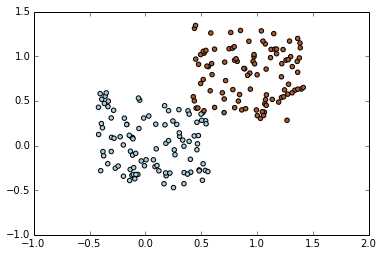

In [26]:
%matplotlib inline
np.random.seed(42)
y = np.concatenate((np.repeat(-1,100),np.repeat(1,100))) 
X = np.random.rand(200,2) 
X[:,0] += 0.425*y
X[:,1] += 0.45*y - X[:,0] * 0.15
np.shape(y)
plt.scatter(X[:,0],X[:,1],c=y, cmap=plt.cm.Paired)
plt.show()

#### The meaning of the parameter C

To get an idea about the meaning of the parameter C we look at the number of support vectors. The support vectors either lie on the wrong side or in the margin. So many support vectors indicate a large margin.

In [40]:
for C in (1e-3, 1e-2, 1e-1, 1, 1e1,1e2,1e10):
    svc = svm.SVC(kernel='linear', C=C).fit(X,y)
    print('C={0} number of SV={1}'.format(C, len(svc.support_vectors_)))

C=0.001 number of SV=200
C=0.01 number of SV=186
C=0.1 number of SV=75
C=1 number of SV=28
C=10.0 number of SV=15
C=100.0 number of SV=9
C=10000000000.0 number of SV=3


The larger the value C is the less SV. Hence with a rising C the margin gets smaller. This is consistent with  Elements of statistical learning and the slides. 

```
The margin is larger for C = 0.01 than it is for C = 10, 000. p421
```

Further the dual form in http://scikit-learn.org/stable/modules/svm.html#svc and Eq. 12.13 in Elements of statistical learning look the same.

### Introducation to statistical learning
The parameter C in the ISLR is different. They always try to maximize the margin M under the constrain $\sum \beta^2 = 1$ and do not set the margin width to 1 and then minimize $\beta$.

In the R example we also talks about a parameter `cost` which is same as the C above.
